In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
from PIL import Image
import random

drive.mount('/content/drive')
npzip = np.load('/content/drive/My Drive/point_cloud_mnist.npz')

Mounted at /content/drive


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Sat Oct 31 10:36:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:

class DataSet(torch.utils.data.Dataset):
    def __init__(self):
        self.data = (torch.from_numpy(npzip['X']).float() - 48.) / 48.
        self.targets = torch.from_numpy(npzip['Y']).long()

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


mb_size = 64
dataset = DataSet()
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=mb_size, shuffle=True, drop_last=True)

In [33]:
class Aggregater(nn.Module):
    def __init__(self, kernel_size):
        super(Aggregater, self).__init__()
        self.kernel_size = kernel_size
        self.maxpooler = nn.AdaptiveMaxPool2d((self.kernel_size, 1))

    def forward(self, x):
        return self.maxpooler(x.reshape(x.size(0), 1, -1, self.kernel_size)).reshape(x.size(0), self.kernel_size)


class Tnet(nn.Module):
    def __init__(self, k):
        super(Tnet, self).__init__()
        self.k = k
        self.H = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, self.k)),
            nn.ReLU(),
            nn.Conv2d(64, 128, 1),
            nn.ReLU(),
            nn.Conv2d(128, 512, 1)
        ).to(device)

        self.G = Aggregater(512).to(device)

        self.F = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.k * self.k)
        ).to(device)

    def forward(self, x):
        
        h = self.H(x)
        g = self.G(h)
        f = self.F(g)
        f = f.reshape(x.size(0), self.k, self.k)
        init = f + torch.eye(self.k, requires_grad=True).repeat(x.size(0),1,1).to(device)
        return init

 
class PointNet(nn.Module):

    def __init__(self):
        super(PointNet, self).__init__()
        self.tnet = Tnet(2)
        self.H = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 2)),
            nn.ReLU(),
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 1),
            nn.ReLU(),
            nn.Conv2d(128, 512, 1)
        ).to(device)

        self.G = Aggregater(512).to(device)

        self.F = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        ).to(device)

    def forward(self, x):

        mat = self.tnet(x.unsqueeze(1))
        
        x_t = torch.bmm(x, mat).unsqueeze(1)
        h = self.H(x_t)
        g = self.G(h)

        f = self.F(g)        
        return f, mat



model = PointNet()
solver = optim.Adam(model.parameters(), lr=1e-5)

0.3619999564555946 0.8953775346851655
0.3586275496280562 0.8967449306296692
0.35701440880621765 0.8968283084311632
0.35477937373115004 0.8978288420490929
0.3539943352675616 0.8975120064034151
0.35071639668916055 0.898962780149413
0.3481099856351457 0.8999799893276414
0.3471884238618161 0.9005803094983992
0.3455760337754273 0.9009138207043756
0.34298094036803045 0.9011472785485592
0.3417321486495984 0.9018309765208111
0.3404136758094918 0.9018976787620064
0.3365808898223248 0.9036486125933831
0.3371732636029845 0.9036819637139808
0.3349368116930684 0.9036819637139808
0.331733464860738 0.9042155816435432
0.3305214775473738 0.9049993329775881
0.3287931573095164 0.9060999199573105
0.3278835587116036 0.9064834578441836
0.3256948779206902 0.9061999733191035
0.32384931075852863 0.9080509605122732
0.32233873704645144 0.9081343383137673
0.3215268086343845 0.9086846318036286
0.3195218160796191 0.9087346584845251
0.31782806488976534 0.9097518676627535
0.3169145732799996 0.9100020010672358
0.31499

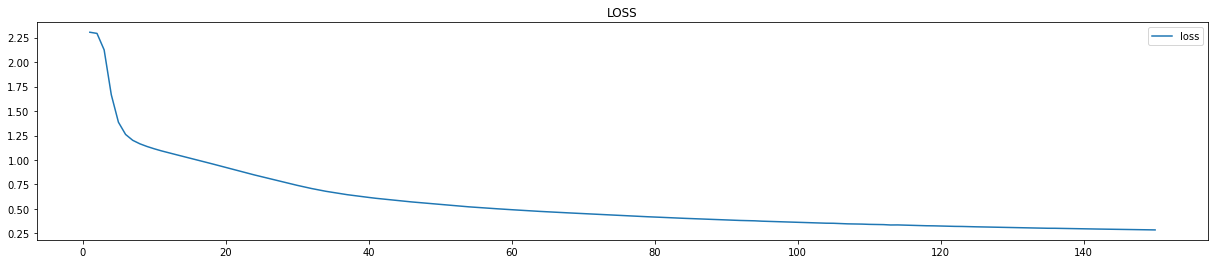

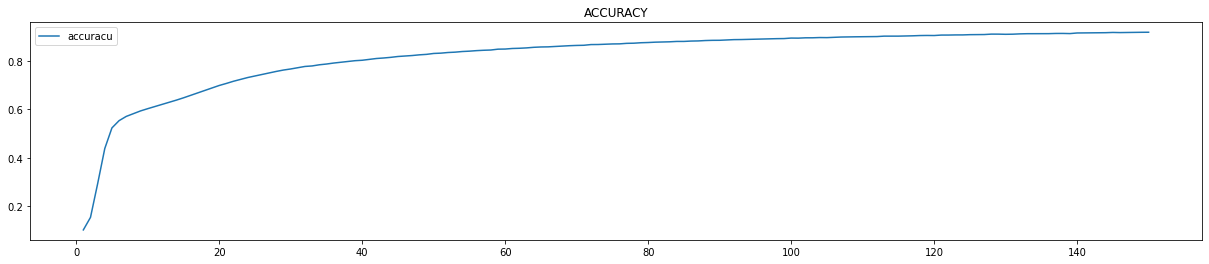

In [35]:
num_epochs = 50
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0
    for _, (X, Y) in enumerate(loader):
        X = X.to(device)
        Y = Y.to(device)
        solver.zero_grad()
        logit, mat = model(X)

        id2x2 = torch.eye(2, requires_grad=True).repeat(X.size(0),1,1).to(device)
        norm =  torch.norm(id2x2 - torch.bmm(mat,mat.transpose(1,2))) / X.size(0)
        loss = F.cross_entropy(logit, Y, reduction='mean') + norm
        loss.backward()
        solver.step()
        epoch_loss += loss.item()

        epoch_accuracy += (torch.argmax(logit.detach(), dim=-1) == Y).sum().item() / mb_size
    LOSS.append(epoch_loss / len(loader))
    ACCURACY.append(epoch_accuracy / len(loader))
    print(LOSS[-1], ACCURACY[-1])

plt.figure(figsize=(21, 4))
plt.title('LOSS')
plt.plot(np.arange(1, len(LOSS) + 1), LOSS, label='loss')
plt.legend()
plt.show()

plt.figure(figsize=(21, 4))
plt.title('ACCURACY')
plt.plot(np.arange(1, len(ACCURACY) + 1), ACCURACY, label='accuracu')
plt.legend()
plt.show()

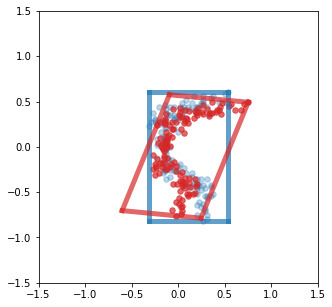

0 :  0.001
1 :  0.000
2 :  0.000
3 :  0.000
4 :  0.000
5 :  0.981
6 :  0.001
7 :  0.000
8 :  0.017
9 :  0.000


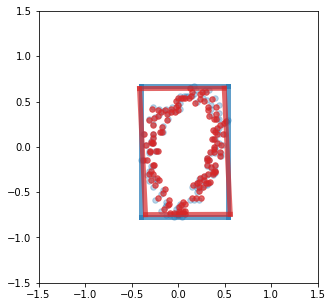

0 :  0.999
1 :  0.000
2 :  0.000
3 :  0.000
4 :  0.000
5 :  0.000
6 :  0.000
7 :  0.000
8 :  0.000
9 :  0.000


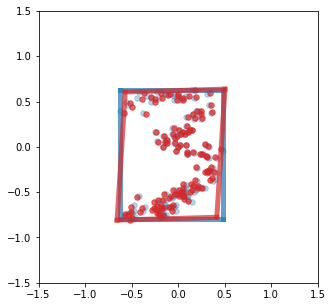

0 :  0.000
1 :  0.000
2 :  0.000
3 :  0.998
4 :  0.000
5 :  0.002
6 :  0.000
7 :  0.000
8 :  0.000
9 :  0.000


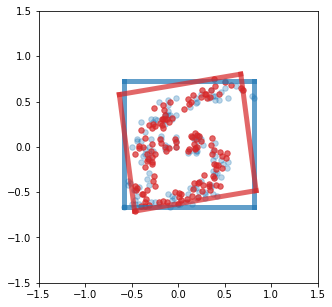

0 :  0.007
1 :  0.000
2 :  0.000
3 :  0.000
4 :  0.000
5 :  0.976
6 :  0.012
7 :  0.000
8 :  0.005
9 :  0.000


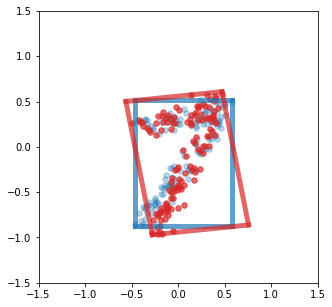

0 :  0.000
1 :  0.000
2 :  0.000
3 :  0.001
4 :  0.000
5 :  0.000
6 :  0.000
7 :  0.984
8 :  0.000
9 :  0.015


In [69]:

def demo(test_index):
    left = torch.min(dataset.data[test_index][:, 0]).item()
    right = torch.max(dataset.data[test_index][:, 0]).item()
    up = torch.max(dataset.data[test_index][:, 1]).item()
    down = torch.min(dataset.data[test_index][:, 1]).item()

    frame = torch.from_numpy(np.array([[left, up], [left, down], [right, up], [right, down]])).unsqueeze(0).to(device).float()


    test_data = dataset.data[test_index].unsqueeze(0).to(device)

    logit, mat = model(test_data)
    frame_t = torch.bmm(frame, mat).squeeze(0)



    plt.figure(figsize=(5, 5))
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.plot([left, left], [up, down], c='tab:blue', linewidth=5, alpha=0.7)
    plt.plot([left, right], [up, up], c='tab:blue', linewidth=5, alpha=0.7)
    plt.plot([right, left], [down, down], c='tab:blue', linewidth=5, alpha=0.7)
    plt.plot([right, right], [up, down], c='tab:blue', linewidth=5, alpha=0.7)


    plt.plot([frame_t[0][0], frame_t[1][0]], [frame_t[0][1], frame_t[1][1]], c='tab:red', linewidth=5, alpha=0.7)
    plt.plot([frame_t[0][0], frame_t[2][0]], [frame_t[0][1], frame_t[2][1]], c='tab:red', linewidth=5, alpha=0.7)
    plt.plot([frame_t[1][0], frame_t[3][0]], [frame_t[1][1], frame_t[3][1]], c='tab:red', linewidth=5, alpha=0.7)
    plt.plot([frame_t[2][0], frame_t[3][0]], [frame_t[2][1], frame_t[3][1]], c='tab:red', linewidth=5, alpha=0.7)


    plt.scatter(dataset.data[test_index, :, 0], dataset.data[test_index, :, 1], s=30, alpha=0.3)

    t_x = torch.bmm(test_data, mat).squeeze(0).detach().cpu().numpy()
    plt.scatter(t_x[:, 0], t_x[:, 1], c='tab:red', s=30, alpha=0.7)
    plt.show()

    np.set_printoptions(precision=3, suppress=True)
    pred = F.softmax(logit[0], dim=-1).cpu().detach().numpy()
    for i in range(10):
        print(i,': ', format(pred[i], '.3f'))
demo(100)
demo(1000)
demo(10000)
demo(20000)
demo(40000)


